# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data


In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [4]:
data['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [5]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data['income'][data['income']=='>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data['income'][data['income']=='<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k * 100/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {0:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [6]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [7]:
numerical_columns = data.describe().columns
numerical_columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

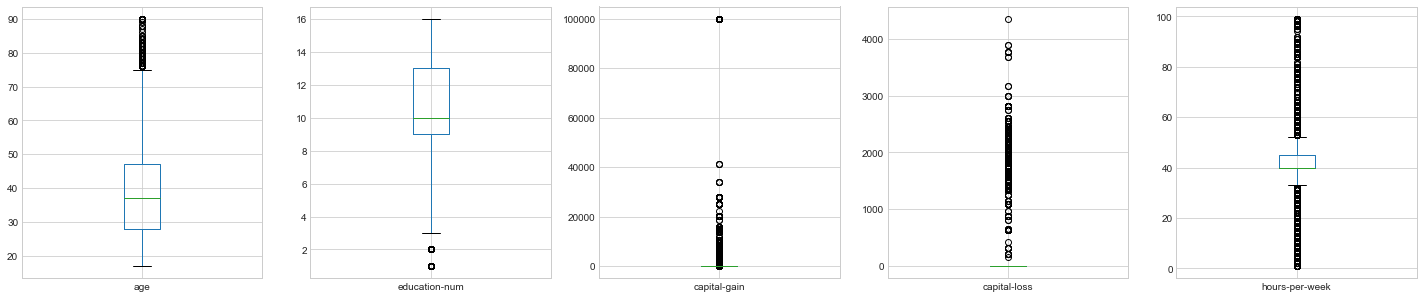

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(25,5))
for i,col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    data[[col]].boxplot(fontsize=10)

In [9]:
def describe_categorical_values(df, non_interesting_columns=[], num_categories=5):
    values_df = pd.DataFrame()
    for i, column in enumerate(df.columns):
        if column in non_interesting_columns:
            continue
        top_values0 = ["{}: {}%".format(x,int(round(100*y/len(df))))
                       for x, y in zip(df[column].value_counts(dropna=False).head(num_categories).index,
                                       df[column].value_counts(dropna=False).head(num_categories).values)]
        if len(top_values0) < num_categories:
            top_values = [None]*num_categories
            top_values[:len(top_values0)] = top_values0
        else:
            top_values = top_values0
        values_df[column] = top_values
    return values_df.transpose()

describe_categorical_values(data, non_interesting_columns=numerical_columns, num_categories=8)

,0,1,2,3,4,5,6,7
workclass,Private: 74%,Self-emp-not-inc: 8%,Local-gov: 7%,State-gov: 4%,Self-emp-inc: 4%,Federal-gov: 3%,Without-pay: 0%,None
education_level,HS-grad: 33%,Some-college: 22%,Bachelors: 17%,Masters: 6%,Assoc-voc: 4%,11th: 4%,Assoc-acdm: 3%,10th: 3%
marital-status,Married-civ-spouse: 47%,Never-married: 32%,Divorced: 14%,Separated: 3%,Widowed: 3%,Married-spouse-absent: 1%,Married-AF-spouse: 0%,None
occupation,Craft-repair: 13%,Prof-specialty: 13%,Exec-managerial: 13%,Adm-clerical: 12%,Sales: 12%,Other-service: 11%,Machine-op-inspct: 7%,Transport-moving: 5%
relationship,Husband: 41%,Not-in-family: 26%,Own-child: 15%,Unmarried: 11%,Wife: 5%,Other-relative: 3%,None,None
race,White: 86%,Black: 9%,Asian-Pac-Islander: 3%,Amer-Indian-Eskimo: 1%,Other: 1%,None,None,None
sex,Male: 68%,Female: 32%,None,None,None,None,None,None
native-country,United-States: 91%,Mexico: 2%,Philippines: 1%,Germany: 0%,Puerto-Rico: 0%,Canada: 0%,El-Salvador: 0%,India: 0%
income,<=50K: 75%,>50K: 25%,None,None,None,None,None,None


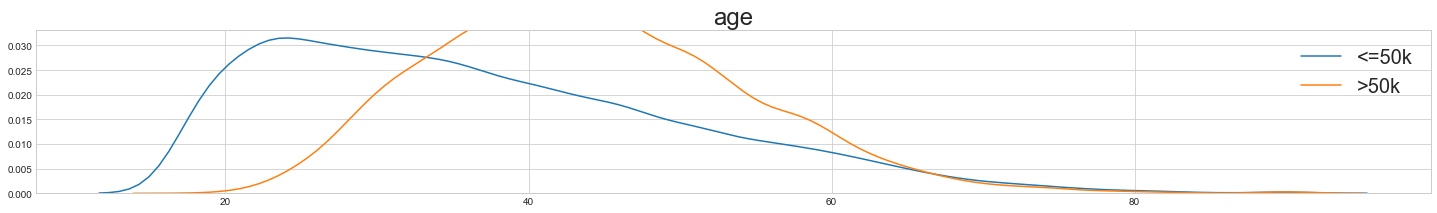

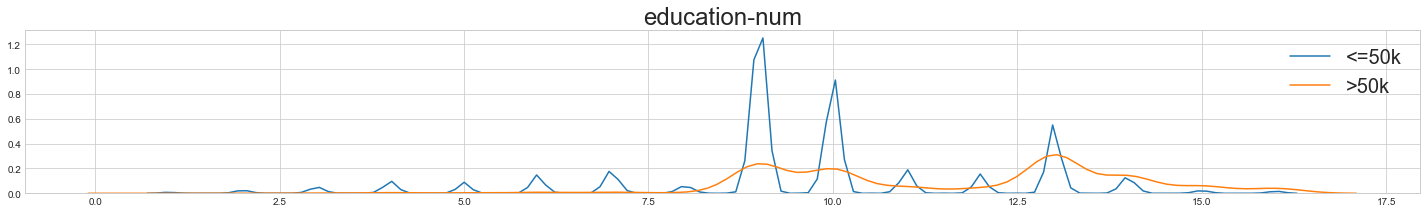

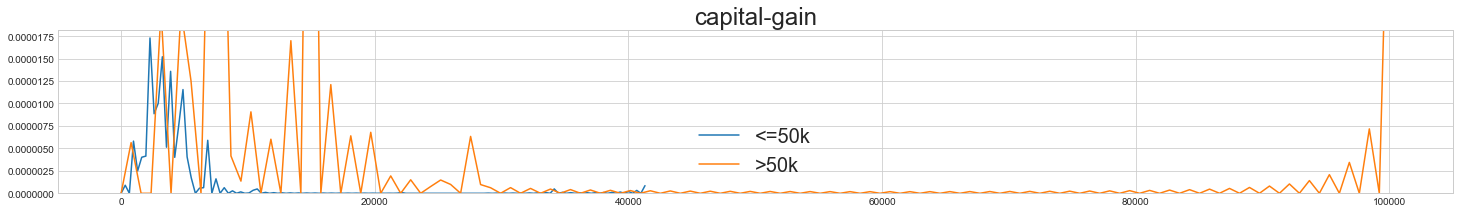

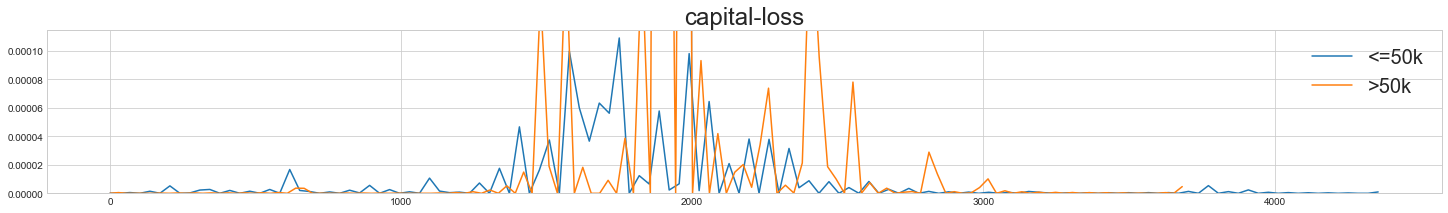

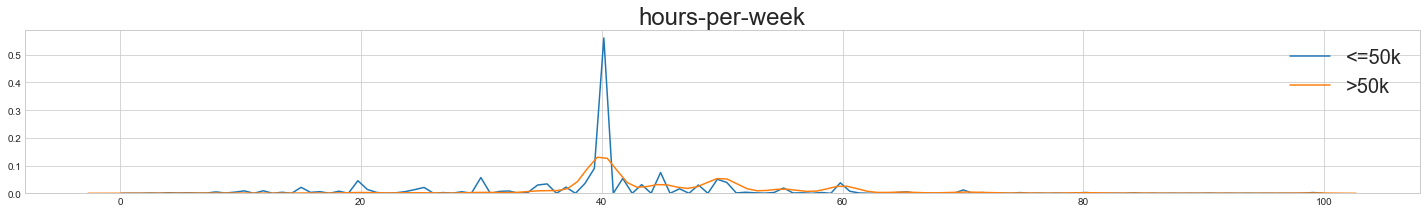

In [10]:
for col in numerical_columns:
    plt.figure(figsize=(25,3))
    sns.kdeplot(data.loc[data['income']=='<=50K', col], label='<=50k')
    sns.kdeplot(data.loc[data['income']=='>50K', col], label='>50k')
    plt.legend(fontsize=20)
    plt.title(col, fontsize=24)

In [11]:
def get_most_correlated_variables(corr, num_pairs=10):
    correlation_melted = pd.melt(corr.reset_index().rename(columns={"index": "var_1"}), id_vars=("var_1"),var_name='var_2')
    correlation_melted = correlation_melted[correlation_melted.var_1!=correlation_melted.var_2]
    correlation_melted['var_couple'] = correlation_melted[['var_1','var_2']].apply(lambda x:tuple(sorted([x[0],x[1]])), axis=1)
    correlation_melted = correlation_melted.drop_duplicates(subset='var_couple').drop(['var_couple'],axis=1)
    correlation_melted['abs_value'] = correlation_melted['value'].abs().round(3)
    return correlation_melted.sort_values(by='abs_value').tail(num_pairs).drop('abs_value', axis=1).reset_index(drop=True)

def plot_correlation_matrix(X, features2):
    corr = X[features2].corr()
     # return the most correlated variables
    most_correlated_variables = get_most_correlated_variables(corr, num_pairs=10)
    max_correlation = 1.25*most_correlated_variables['value'].abs().max()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax.set_yticklabels(features2, fontsize=18)
    ax.set_xticklabels(features2, rotation='vertical', fontsize=18)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=max_correlation, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    return most_correlated_variables

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features


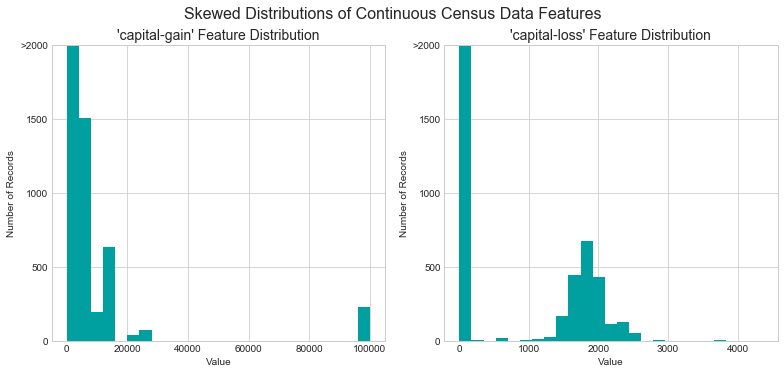

In [12]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

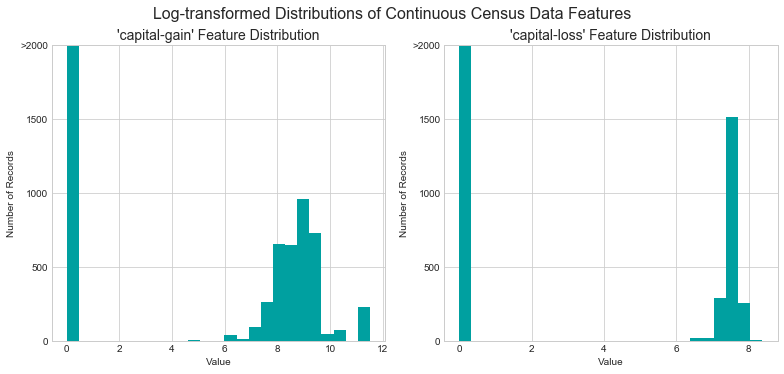

In [13]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

,var_1,var_2,value
0,education-num,age,0.037623
1,hours-per-week,capital-loss,0.051587
2,capital-loss,age,0.055331
3,capital-loss,capital-gain,-0.066899
4,capital-loss,education-num,0.078967
5,hours-per-week,capital-gain,0.086098
6,hours-per-week,age,0.101992
7,capital-gain,age,0.122068
8,capital-gain,education-num,0.129347
9,hours-per-week,education-num,0.146206


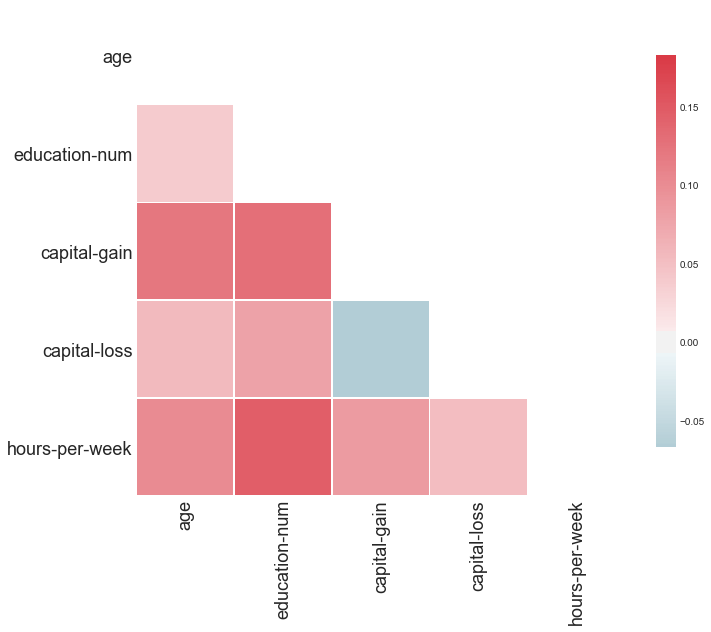

In [14]:
plot_correlation_matrix(features_raw, features_raw.columns.values)

### Normalizing Numerical Features


In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] # or user numerical_columns

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing


In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['<=50K','>50K'])
le.transform(data.income)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [17]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [18]:
income[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

### Shuffle and Split Data


In [19]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\Idan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
y_train[:10]

13181    0
10342    0
20881    0
24972    1
43867    0
4124     0
17641    0
17273    0
41191    0
5386     1
Name: income, dtype: int64

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

In [21]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count()
TN = 0
FN = 0

accuracy = greater_percent/100.0
recall = TP/(TP+FN)
precision = TP/(TP+FP)
beta = 0.5

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + np.square(beta)) * accuracy * recall / (np.square(beta) * accuracy + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


In [22]:
print(TP, FP, TN, FN, accuracy, recall, precision)

11208 45222 0 0 0.2478439697492371 1.0 0.198617756512


### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.


In [23]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation


LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
SVC trained on 361 samples.


C:\Users\Idan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


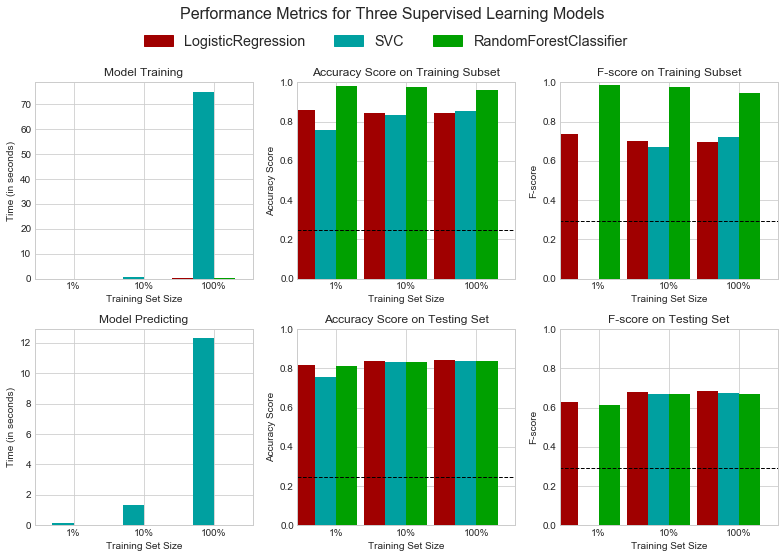

In [24]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = LogisticRegression(random_state=1)
clf_B = SVC(random_state=1)
clf_C = RandomForestClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(0.1 * len(X_train))
samples_1 = int(0.01 * len(X_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this.

In [25]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {"C":[0.01,0.1,0.25,0.5,0.75,10,50],"penalty":["l1","l2"]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get best parameters
best_param = grid_fit.best_params_

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print ("best params:"+str(best_param))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\Idan\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
best params:{'C': 0.1, 'penalty': 'l2'}
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6842


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |naive predictor benchmarks|
| :------------: | :---------------: | :-------------: | :-----------------------:|
| Accuracy Score |          0.8419   |       0.8420    |     0.1986               |
| F-score        |          0.6832   |       0.6842    |     0.2365               |


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.


### Implementation - Extracting Feature Importance


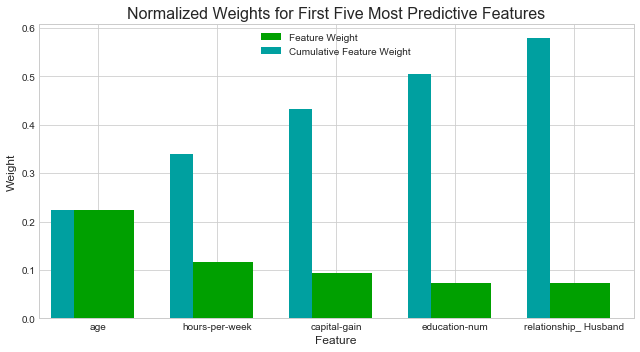

In [26]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

In [27]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6842

Final Model trained on reduced data
------
Accuracy on testing data: 0.8235
F-score on testing data: 0.6420


## My playground 

In [28]:
%matplotlib inline
def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.ix[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, train, test, y_train, y_test):
    probabilities = model.predict_proba(test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    plt.figure()
    plt.plot(fpr, tpr, label='test')
    roc_auc = roc_auc_score(y_test, probabilities)
    probabilities = model.predict_proba(train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities)
    plt.plot(fpr, tpr, label='train')
    plt.plot([0, 1], [0, 1], 'r--', label='random guess')
    plt.title("area under the ROC curve = {}".format(roc_auc), fontsize=18);
    print(classification_report(y_test, predictions))
    plt.legend()

             precision    recall  f1-score   support

          0       0.94      0.78      0.85      6840
          1       0.56      0.84      0.67      2205

avg / total       0.85      0.80      0.81      9045



C:\Users\Idan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


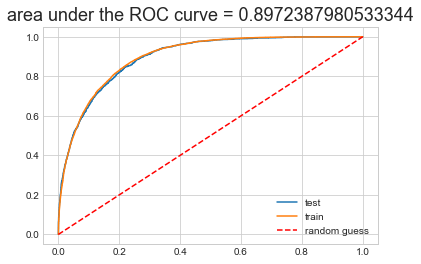

In [29]:
model = make_pipeline(MinMaxScaler(),LogisticRegression())
model.fit(X_train, y_train)
get_model_results(model, X_train, X_test, y_train, y_test)

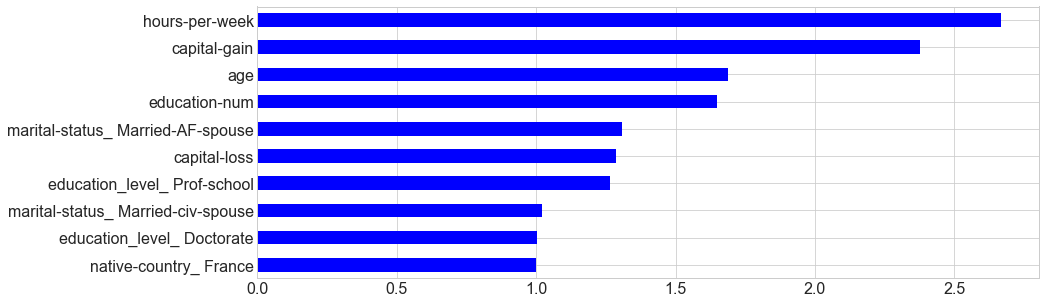

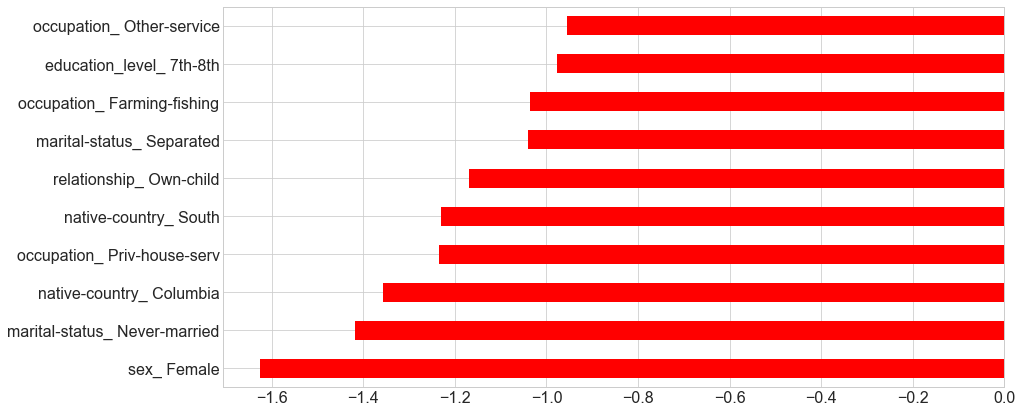

In [30]:
feature_importance = pd.Series(index=X_train.columns , data= model.named_steps['logisticregression'].coef_[0])
feature_importance = feature_importance.sort_values()
plt.figure(figsize=(14,5))
feature_importance.tail(10).plot.barh(fontsize=16,color='b' )
plt.figure(figsize=(14,5))
feature_importance.head(10).plot.barh(fontsize=16, figsize=(14,7), color='r')

             precision    recall  f1-score   support

          0       0.93      0.79      0.85      6840
          1       0.56      0.82      0.66      2205

avg / total       0.84      0.80      0.81      9045



C:\Users\Idan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


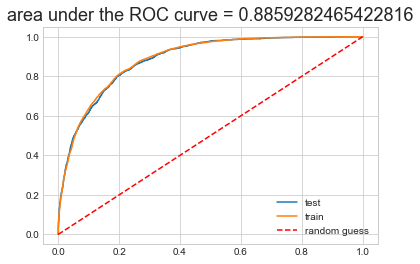

In [31]:
from sklearn.decomposition import PCA

model = make_pipeline(PCA(n_components=30,whiten=False),LogisticRegression())
model.fit(X_train, y_train)
get_model_results(model, X_train, X_test, y_train, y_test)

In [32]:
poly = PolynomialFeatures(2)
train_poly_features = poly.fit_transform(X_train[numerical_columns])
test_poly_features = poly.transform(X_test[numerical_columns])
train_with_poly_features = pd.concat([X_train.reset_index(drop=True),pd.DataFrame(train_poly_features)],axis=1)
test_with_poly_features = pd.concat([X_test.reset_index(drop=True),pd.DataFrame(test_poly_features)],axis=1)

C:\Users\Idan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


             precision    recall  f1-score   support

          0       0.94      0.82      0.88      6840
          1       0.60      0.82      0.70      2205

avg / total       0.85      0.82      0.83      9045



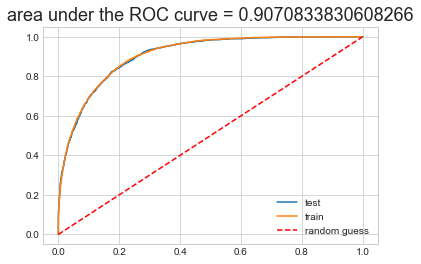

In [33]:
model = make_pipeline(MinMaxScaler(),LogisticRegression())
model.fit(train_with_poly_features, y_train)
get_model_results(model, train_with_poly_features, test_with_poly_features, y_train, y_test)